# Exercise 11

## Notice: This takes around 2 minutes to run since our random generator is a bit slow....be patient please

### a) Signal MC
The energy dependent flow of neutrionos can be seen as a propability distribution with

\begin{equation}
    \Phi(E) = \Phi_0 \left( \frac{E}{\mathrm{TeV}}\right)^{-\gamma}
\end{equation}

Using $E' = E/\mathrm{TeV}$

Normalization:

\begin{align}
    &\int_1^\infty \Phi(E') \mathrm{d}E' \stackrel{!}{=}  ! \\
    \Leftrightarrow &\int_1^\infty \Phi_0 \left( E'\right)^{-\gamma} \mathrm{d}E'= 1 \\
    \Leftrightarrow & \Phi_0 \left[\frac{1}{1-\gamma}\left(E'\right)^{1-\gamma} \right]^\infty_1 = 1 \\
    \Leftrightarrow & \Phi_0 = \gamma -1
\end{align}

Inversion of 
\begin{align}
    u &= \int_1^{E'} \Phi(\tilde{E}) \mathrm{d}\tilde{E} = 1 - E'^{1-\gamma} \\
    \Leftrightarrow E &= \sqrt[1- \gamma]{1-u}
\end{align}

gives the wanted transformation for uniform distributed $u$ to $E'$ with distribution $\Phi(E')$ 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

gamma = 2.7

rng = np.random.default_rng(seed = 0)  

u = rng.uniform(size = 10**5)    # creating uniform distributed values using the numpy rng

E = (1-u)**(1/(1 - gamma))       # Transformation to wanted distribution

df = pd.DataFrame(
    {
        "Energy": E
    }
)

### b) Acceptance

In [2]:
# how should the Neumann rejection method deliver boolean values??? makes no sense to me, so I do smth different
def P(E):
    return (1 - np.exp(-E/2))**3

mask = np.array(np.ones(10**5), dtype = bool)
u = rng.uniform(size = 10**5)   # random number between 0 and 1
for i in range(10**5):
    if u[i] > P(E[i]):         # e.g. P(E) = 0.4 --> 40 % of all random numbers in u are <= P(E) --> 40% chance of detection
        mask[i] = False
        
df["AcceptanceMask"] = mask

Plots:

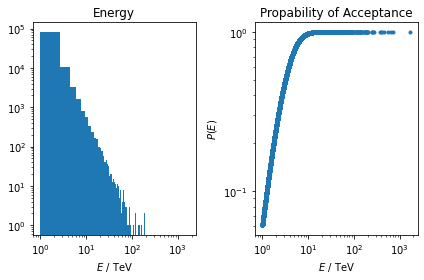

In [3]:
plt.subplot(1, 2, 1)
plt.hist(E, bins = 1000)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$E$ / TeV")
plt.title("Energy")

plt.subplot(1, 2, 2)
plt.plot(E, P(E), ".")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("$E$ / TeV")
plt.ylabel("$P(E)$")
plt.title("Propability of Acceptance")
plt.tight_layout()


### d) Energy measurement

In [4]:
from project_a1.random import Generator

gen = Generator(seed=0)

N = np.zeros(10**5)

for i in range(10**5):
    temp = -1
    while temp < 0:
        temp = gen.normal(loc = 10*E[i], scale = 2*E[i])
    N[i] = np.around(temp)
   
df["NumberOfHits"] = N

### e) Spacial measurement

In [5]:
x_0, y_0 = 7, 3
x, y = -1*np.ones(shape = (2, 10**5))

for i in range(10**5):
    while x[i] < 0 or x[i]>10:
        x[i] = gen.normal(loc = x_0, scale = 1/np.log10(N[i]+1))
    while y[i] < 0 or y[i]>10:
        y[i] = gen.normal(loc = y_0, scale = 1/np.log10(N[i]+1))   
     
df["x"] = x
df["y"] = y

In [6]:
df.to_hdf("NeutrinoMC.hdf5", key = "Signal")

Text(0.5, 1.0, 'Signal')

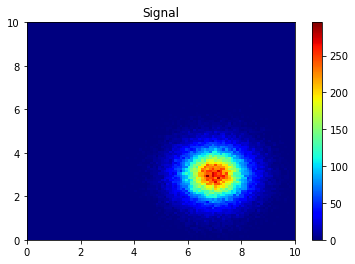

In [7]:
fig = plt.subplot(1,1,1)
plt.hist2d(x, y, bins=(100, 100), range = [[0, 10], [0, 10]], cmap=plt.cm.jet)
plt.colorbar()
plt.title("Signal")

### f) Underground MC

In [8]:
n = 10**7
N2 = 10**gen.normal(loc = 2, scale = 1, size = n)

In [9]:
sigma = 3
mu = 5
p = 0.5
a = np.sqrt(1-p**2)*sigma
b = sigma*p

x2_, y2_ = gen.standard_normal(size = (2, n))
x2 = a*x2_ + b*y2_ + mu 
y2 = sigma*y2_ + mu
for i in range(n):
    while x2[i] < 0 or x2[i] > 10 or y2[i] < 0 or y2[i] > 10:
        x2_[i], y2_[i] = gen.standard_normal(size = (2, 1))
        x2[i] = a*x2_[i] + b*y2_[i] + mu
        y2[i] = sigma*y2_[i] + mu

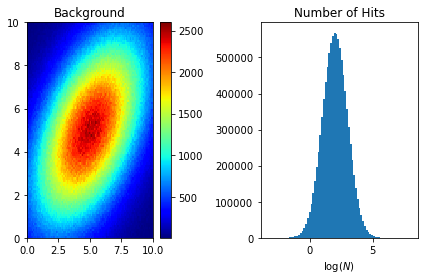

In [10]:
plt.subplot(1, 2, 1)
plt.hist2d(x2, y2, bins=(100, 100), range = [[0, 10], [0, 10]], cmap=plt.cm.jet)
plt.title("Background")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.hist(np.log10(N2), bins = 80)
plt.xlabel("$\mathrm{log}(N)$")
#plt.yscale('log')
plt.title("Number of Hits")
plt.tight_layout()

N2 = np.around(N2) # N must be a whole number, could'nt do this before the plot though, because it would give log(0)

In [11]:
df2 = pd.DataFrame(
    {
        "NumberOfHits": N2,
        "x": x2,
        "y": y2
    }
)
df2.to_hdf("NeutrinoMC.hdf5", key = "Background")